# Spectroscopic Data Reduction

Spectroscopic data reduction is the process of converting raw spectroscopic images from a spectrograph into a calibrated spectrum. This process involves several steps, including bias subtraction, flat fielding, wavelength calibration, and extraction of the spectrum. In this notebook, we will go through the process of reducing a spectroscopic image using Python.

The CCD pre-processing steps are as usual: bias/dark subtraction, flat fielding, and cosmic ray removal. The spectroscopic data reduction steps are: extraction of the spectrum, wavelength calibration and flux calibration. Here we will focus mostly on the spectroscopic data reduction steps. After the data reduction, the spectrum can be used for scientific analysis, such as measuring redshifts, line identifications, and measuring line fluxes. In this notebook, we will reduce a 2D spectrum of an afterglow of a gamma-ray burst (GRB). Since this tutorial is prepared for the [Project No. 5 of our TAO class](https://hbahk.github.io/TAOtutorials/tutorials/Proj5_Spectroscopic_Data_Analysis), I leave the scientific analysis of the spectrum to readers.

The data used in this notebook is from the Subaru Telescope's Faint Object Camera and Spectrograph (FOCAS). The data is 2D images of a spectrum of an afterglow of a GRB, GRB 130606A, which is a significantly redshifted source at $z\sim5.9$. The data was taken on June 7, 2013, using the VPH900 grism, which covers the wavelength range of 7500-10450 Angstroms ([Subaru FOCAS Hompage](https://www.naoj.org/Observing/Instruments/FOCAS/index.html)).

Let's start by organizing the data and displaying the 2D spectral images.

In [1]:
import warnings
from datetime import datetime
from pathlib import Path

import numpy as np
import preproc  # custom module for data reduction
from astropy.io import ascii, fits
from astropy.modeling.fitting import LevMarLSQFitter
from astropy.modeling.models import Chebyshev2D, Gaussian1D
from astropy.nddata import CCDData
from astropy.stats import gaussian_fwhm_to_sigma, sigma_clip
from astropy.table import Column, Table
from astropy.visualization import ZScaleInterval
from ccdproc import combine, cosmicray_lacosmic, gain_correct
from IPython.display import Image
from matplotlib import gridspec
from matplotlib import pyplot as plt
from matplotlib import rc, rcParams
from mpl_toolkits.axes_grid1 import make_axes_locatable
from numpy.polynomial.chebyshev import chebfit, chebval
from scipy.interpolate import UnivariateSpline
from scipy.ndimage import median_filter
from scipy.optimize import curve_fit
from skimage.feature import peak_local_max

# plt.rcParams['axes.linewidth'] = 2
plt.rcParams["font.size"] = 12
plt.rcParams["axes.labelsize"] = 14

WD = Path("./data/proj5")
RAWDIR = WD / "raw" / "P03hbahk0304145443GZ_data"
OUTDIR = WD / "out"

if not OUTDIR.exists():
    OUTDIR.mkdir(parents=True)

warnings.filterwarnings("ignore", category=UserWarning, append=True)

In [2]:
def make_summary_table_focas(rawdir, suffix='.fits.gz'):
    """Make a summary table of the raw data in the directory. This function is
    specifically designed for the data taken with the FOCAS instrument.

    Args:
        rawdir (pathlib.Path): The directory containing the raw data.
        suffix (str, optional): The suffix of the raw data files. Defaults to
            '.fits.gz'.

    Returns:
        stab (astropy.table.Table): The summary table of the raw data in the directory.
        
    """
    # making a summary table
    summary = []
    for f in rawdir.glob('*'+suffix):
        hdr = fits.getheader(f)
        
        # getting the filter information from the header
        filt1 = hdr['FILTER01']
        filt2 = hdr['FILTER02']
        filt3 = hdr['FILTER03']
            
        X = hdr['AIRMASS'] # airmass
        disp = hdr['DISPERSR'] # disperser
        
        # appending the data to the summary list
        summary.append([f.name, hdr['DATE-OBS'], hdr['OBJECT'], hdr['RA'], hdr['DEC'],
                        hdr['DATA-TYP'], hdr['EXPTIME'], X, hdr['ALTITUDE'], disp,
                        hdr['SLT-WID'], hdr['SLT-PA'], hdr['SLIT'], filt1, filt2, filt3,
                        hdr['UT-STR'], hdr['UT-END']])
        
    # creating the summary table
    stab = Table(rows=summary,
                 names=['filename', 'date-obs', 'object', 'ra', 'dec', 'type',
                        'exptime', 'airmass', 'altitude', 'disperser', 'slit-width',
                        'slit-pa', 'slit', 'filter1', 'filter2','filter3', 'ut-str', 'ut-end'],
                 dtype=['U50', 'U50', 'U50', 'U50', 'U50', 'U50', 'f8', 'f8', 'f8',
                        'U50', 'f8', 'f8', 'U50', 'U50', 'U50', 'U50', 'U50', 'U50'])
    return stab

summary_table = make_summary_table_focas(RAWDIR)

In [3]:
summary_table

filename,date-obs,object,ra,dec,type,exptime,airmass,altitude,disperser,slit-width,slit-pa,slit,filter1,filter2,filter3,ut-str,ut-end
str50,str50,str50,str50,str50,str50,float64,float64,float64,str50,float64,float64,str50,str50,str50,str50,str50,str50
FCSA00141794.fits.gz,2013-06-07,DOMEFLAT,11:17:48.038,+19:54:08.26,DOMEFLAT,3.0,1.0,89.9361,SCFCGRHD90,0.5,-90.3,SCFCSLLC08,NONE,SCFCFLSO58,NONE,04:37:11.906,04:37:15.139
FCSA00141920.fits.gz,2013-06-07,GRB 130606A,16:37:41.157,+29:47:45.71,OBJECT,1200.0,1.136,61.6129,SCFCGRHD90,0.5,-90.3,SCFCSLLC08,NONE,SCFCFLSO58,NONE,07:59:00.676,08:19:01.117
FCSA00141930.fits.gz,2013-06-07,GRB 130606A,16:37:41.230,+29:47:45.13,OBJECT,1200.0,1.038,74.4191,SCFCGRHD90,0.5,-90.3,SCFCSLLC08,NONE,SCFCFLSO58,NONE,09:03:28.980,09:23:29.405
FCSA00141848.fits.gz,2013-06-07,BIAS,11:39:50.841,+19:54:11.18,BIAS,0.0,1.0,89.9361,SCFCGRMR01,0.5,-90.3,SCFCSLLC20,NONE,SCFCFLSO58,NONE,04:59:10.571,04:59:10.574
FCSA00141916.fits.gz,2013-06-07,GRB 130606A,16:37:41.020,+29:47:44.75,OBJECT,1200.0,1.254,52.8249,SCFCGRHD90,0.5,-90.3,SCFCSLLC08,NONE,SCFCFLSO58,NONE,07:18:00.165,07:38:00.608
FCSA00141734.fits.gz,2013-06-06,BIAS,21:41:03.767,+17:46:28.41,BIAS,0.0,1.001,86.8997,SCFCGRHD90,0.5,-0.3,SCFCSLLC20,NONE,SCFCFLSO58,NONE,14:53:03.807,14:53:03.810
FCSA00141566.fits.gz,2013-06-06,DOMEFLAT,11:23:03.374,+19:54:09.25,DOMEFLAT,1.1,1.0,89.9625,SCFCGRHD90,0.5,-90.3,SCFCSLLC20,NONE,SCFCFLSO58,NONE,04:46:28.971,04:46:30.721
FCSA00141576.fits.gz,2013-06-06,DOMEFLAT,11:26:18.779,+19:54:09.76,DOMEFLAT,3.0,1.0,89.9625,SCFCGRHD90,0.5,-90.3,SCFCSLLC08,NONE,SCFCFLSO58,NONE,04:49:43.639,04:49:46.993
FCSA00141822.fits.gz,2013-06-07,DOMEFLAT,11:26:05.681,+19:54:09.65,DOMEFLAT,1.1,1.0,89.9361,SCFCGRHD90,0.5,-90.3,SCFCSLLC20,NONE,SCFCFLSO58,NONE,04:45:27.990,04:45:29.664


In [4]:
biastab = summary_table[summary_table['type'] == 'BIAS']
flattab = summary_table[summary_table['type'] == 'DOMEFLAT']
arctab = summary_table[(summary_table['type'] == 'COMPARISON') &
                       (summary_table['slit'] == 'SCFCSLLC08')]
scitab = summary_table[summary_table['object'] == 'GRB 130606A']
stdtab_f110 = summary_table[(summary_table['object'] == 'Feige110') &
                            (summary_table['type'] == 'OBJECT')]
stdtab_f34 = summary_table[(summary_table['object'] == 'Feige34') &
                            (summary_table['type'] == 'OBJECT')]

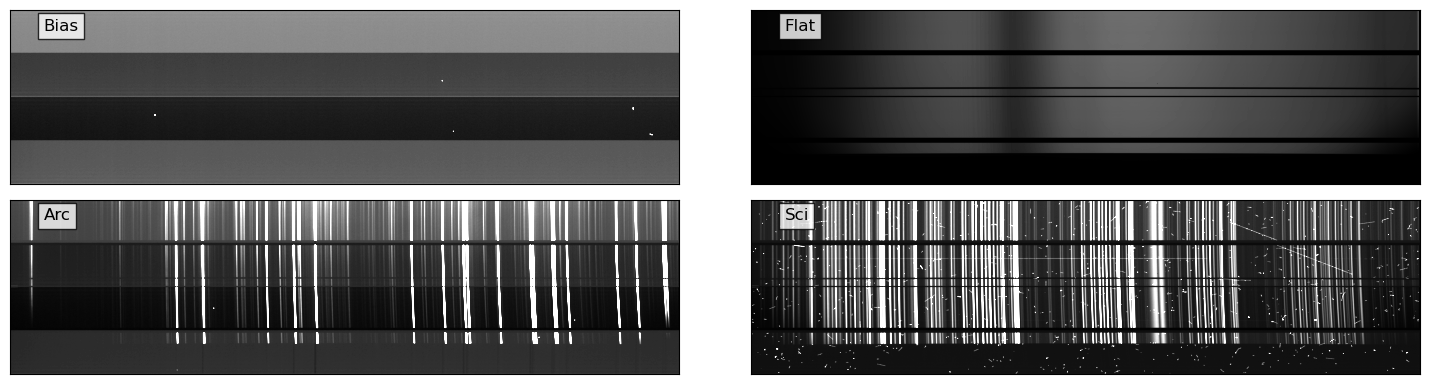

In [5]:
# for displaying in zscale
interval = ZScaleInterval()

# plotting the images
fig, axes = plt.subplots(2, 2, figsize=(15, 4))
titles = ['Bias', 'Flat', 'Arc', 'Sci']
bias = fits.getdata(RAWDIR / biastab['filename'][0])
flat = fits.getdata(RAWDIR / flattab['filename'][0])
arc = fits.getdata(RAWDIR / arctab['filename'][0])
sci = fits.getdata(RAWDIR / scitab['filename'][0])
for i, img in enumerate([bias, flat, arc, sci]):
    vmin, vmax = interval.get_limits(img)
    ax = axes[i // 2][i % 2]
    ax.imshow(img.T, cmap='gray', origin='lower', vmin=vmin, vmax=vmax)
    ax.text(0.05, 0.95, titles[i], transform=ax.transAxes, ha='left', va='top',
            bbox=dict(facecolor='white', alpha=0.8))
    ax.tick_params(axis='both', length=0.0, labelleft=False, labelbottom=False)
plt.tight_layout()

del bias, flat, arc, sci

## Preprocessing of the Raw Images

Preprocessing of the raw images is the first step in the data reduction process. The raw images are usually not ready for scientific analysis and need to be preprocessed before they can be used for scientific analysis. The preprocessing steps include the following:

1. Bias subtraction
2. Dark subtraction
3. Flat fielding
4. Cosmic ray removal

There are lots of software available for preprocessing the raw images. In this tutorial, we will use the `ccdproc` package for preprocessing the raw images. The `ccdproc` package is a Python package for reducing astronomical data taken with CCD cameras. It provides many of the necessary tools for processing of CCD images. For more information on the `ccdproc` package, please visit the [documentation](https://ccdproc.readthedocs.io/en/latest/), and for the complete guide on the reduction process for astronomical images using Python, [CCD Reduction and Photometry Guide](https://www.astropy.org/ccd-reduction-and-photometry-guide/v/dev/notebooks/00-00-Preface.html).

In this notebook, we will preprocess the raw images using `preproc.py` script. This script is available in the tutorial directory. Dark subtraction will not be performed in this notebook since the amount of dark current in the images is negligible.

### Making the Master Bias

Before making the master bias, we need to check the bias images for any defects. We skip this step here, but it is important to check since the bias images are used to calibrate all the other images. If there are defects in the bias images, they will be propagated to all the other images.

The master bias is made by combining all the bias images. The master bias will be subtracted from all the images to remove the bias level. For combining the bias images, the sigma-clipping algorithm is used to reject outliers and then the average of the remaining images is calculated.

In [6]:
biaslist = [RAWDIR / f for f in biastab['filename']]
_ = preproc.combine_bias(biaslist, outdir=OUTDIR, outname='MBias.fits')
del _

INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: An exception happened while extracting WCS information from the Header.
InconsistentAxisTypesError: ERROR 4 in wcs_types() at line 3140 of file cextern/wcslib/C/wcs.c:
Unmatched celestial axes.
 [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: An exception happened while extracting WCS information from the Header.
InconsistentAxisTypesError: ERROR 4 in wcs_types() at line 3140 of file cextern/wcslib/C/wcs.c:
Unmatched celestial axes.
 [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: An exception happened while extracting WCS information from the Header.
InconsistentAxisTypesError: ERROR 4 in wcs_types() at line 3140 of file cextern/wcslib/C/wcs.c:
Unmatched celestial 

this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set DATE-END to '2013-06-07T04:59:10.645' from MJD-END'. [astropy.wcs.wcs]
  'degree' -> 'deg'. [astropy.wcs.wcs]
Set DATE-END to '2013-06-06T14:53:03.880' from MJD-END'. [astropy.wcs.wcs]
Set DATE-END to '2013-06-06T04:56:58.652' from MJD-END'. [astropy.wcs.wcs]


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: An exception happened while extracting WCS information from the Header.
InconsistentAxisTypesError: ERROR 4 in wcs_types() at line 3140 of file cextern/wcslib/C/wcs.c:
Unmatched celestial axes.
 [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: An exception happened while extracting WCS information from the Header.
InconsistentAxisTypesError: ERROR 4 in wcs_types() at line 3140 of file cextern/wcslib/C/wcs.c:
Unmatched celestial axes.
 [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: An exception happened while extracting WCS information from the Header.
InconsistentAxisTypesError: ERROR 4 in wcs_types() at line 3140 of file cextern/wcslib/C/wcs.c:
Unmatched celestial 

Set DATE-END to '2013-06-07T04:59:35.780' from MJD-END'. [astropy.wcs.wcs]
Set DATE-END to '2013-06-07T15:06:35.545' from MJD-END'. [astropy.wcs.wcs]
Set DATE-END to '2013-06-07T05:00:00.751' from MJD-END'. [astropy.wcs.wcs]


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: An exception happened while extracting WCS information from the Header.
InconsistentAxisTypesError: ERROR 4 in wcs_types() at line 3140 of file cextern/wcslib/C/wcs.c:
Unmatched celestial axes.
 [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: An exception happened while extracting WCS information from the Header.
InconsistentAxisTypesError: ERROR 4 in wcs_types() at line 3140 of file cextern/wcslib/C/wcs.c:
Unmatched celestial axes.
 [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: An exception happened while extracting WCS information from the Header.
InconsistentAxisTypesError: ERROR 4 in wcs_types() at line 3140 of file cextern/wcslib/C/wcs.c:
Unmatched celestial 

Set DATE-END to '2013-06-06T04:56:34.054' from MJD-END'. [astropy.wcs.wcs]
Set DATE-END to '2013-06-07T15:07:00.686' from MJD-END'. [astropy.wcs.wcs]
Set DATE-END to '2013-06-07T15:07:53.456' from MJD-END'. [astropy.wcs.wcs]


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: An exception happened while extracting WCS information from the Header.
InconsistentAxisTypesError: ERROR 4 in wcs_types() at line 3140 of file cextern/wcslib/C/wcs.c:
Unmatched celestial axes.
 [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: An exception happened while extracting WCS information from the Header.
InconsistentAxisTypesError: ERROR 4 in wcs_types() at line 3140 of file cextern/wcslib/C/wcs.c:
Unmatched celestial axes.
 [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: An exception happened while extracting WCS information from the Header.
InconsistentAxisTypesError: ERROR 4 in wcs_types() at line 3140 of file cextern/wcslib/C/wcs.c:
Unmatched celestial 

Set DATE-END to '2013-06-06T04:56:09.042' from MJD-END'. [astropy.wcs.wcs]
Set DATE-END to '2013-06-06T14:53:29.035' from MJD-END'. [astropy.wcs.wcs]
Set DATE-END to '2013-06-07T15:06:10.558' from MJD-END'. [astropy.wcs.wcs]


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: An exception happened while extracting WCS information from the Header.
InconsistentAxisTypesError: ERROR 4 in wcs_types() at line 3140 of file cextern/wcslib/C/wcs.c:
Unmatched celestial axes.
 [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: An exception happened while extracting WCS information from the Header.
InconsistentAxisTypesError: ERROR 4 in wcs_types() at line 3140 of file cextern/wcslib/C/wcs.c:
Unmatched celestial axes.
 [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: An exception happened while extracting WCS information from the Header.
InconsistentAxisTypesError: ERROR 4 in wcs_types() at line 3140 of file cextern/wcslib/C/wcs.c:
Unmatched celestial 

Set DATE-END to '2013-06-06T04:55:19.314' from MJD-END'. [astropy.wcs.wcs]
Set DATE-END to '2013-06-07T04:58:45.726' from MJD-END'. [astropy.wcs.wcs]
Set DATE-END to '2013-06-06T14:52:38.925' from MJD-END'. [astropy.wcs.wcs]


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: An exception happened while extracting WCS information from the Header.
InconsistentAxisTypesError: ERROR 4 in wcs_types() at line 3140 of file cextern/wcslib/C/wcs.c:
Unmatched celestial axes.
 [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: An exception happened while extracting WCS information from the Header.
InconsistentAxisTypesError: ERROR 4 in wcs_types() at line 3140 of file cextern/wcslib/C/wcs.c:
Unmatched celestial axes.
 [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: An exception happened while extracting WCS information from the Header.
InconsistentAxisTypesError: ERROR 4 in wcs_types() at line 3140 of file cextern/wcslib/C/wcs.c:
Unmatched celestial 

Set DATE-END to '2013-06-07T15:07:26.756' from MJD-END'. [astropy.wcs.wcs]
Set DATE-END to '2013-06-06T14:52:13.481' from MJD-END'. [astropy.wcs.wcs]
Set DATE-END to '2013-06-07T05:00:25.744' from MJD-END'. [astropy.wcs.wcs]


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: An exception happened while extracting WCS information from the Header.
InconsistentAxisTypesError: ERROR 4 in wcs_types() at line 3140 of file cextern/wcslib/C/wcs.c:
Unmatched celestial axes.
 [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: An exception happened while extracting WCS information from the Header.
InconsistentAxisTypesError: ERROR 4 in wcs_types() at line 3140 of file cextern/wcslib/C/wcs.c:
Unmatched celestial axes.
 [astropy.nddata.ccddata]


Set DATE-END to '2013-06-06T04:55:43.954' from MJD-END'. [astropy.wcs.wcs]
Set DATE-END to '2013-06-06T14:51:48.267' from MJD-END'. [astropy.wcs.wcs]


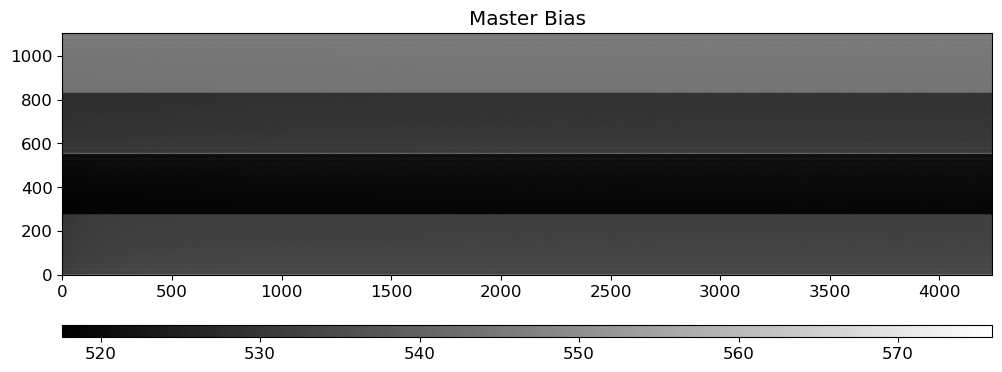

In [7]:
mbias = OUTDIR / 'MBias.fits'
mbias_img = fits.getdata(mbias)
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111)
vmin, vmax = interval.get_limits(mbias_img)
im = ax.imshow(mbias_img.T, cmap='gray', origin='lower', vmin=vmin, vmax=vmax)
ax.set_title('Master Bias')
divider = make_axes_locatable(ax)
cax = divider.append_axes('bottom', size='5%', pad=0.5)
plt.colorbar(im, cax=cax, orientation='horizontal')

### Making Master Flat
Not like the photometric observation, spectroscopic flat image is typically taken with something like halogen lamp or tungsten lamp, which is inevitably not uniform especially for the dispersion direction. Therefore, we need to make a master flat image *flat*, which involves modeling the flat spectrum and dividing the flat image by the model. To obtain a good master flat, we need to:
1. **Examine the flat spectra**: do they show any variablity throughout the observation? can we combine them without any further consideration? do they have any features like wiggles or bumps? do they have any discontinuity?
2. **Model the flat spectra**: we can use a polynomial (or smoothing convolution) to model the flat spectrum. The degree of the polynomial (or size of the smoothing kernel) should be determined by the complexity of the flat spectrum.
3. **Normalize the flat spectra**: divide the flat image by the model to obtain a normalized flat image.

Combining can be done either before or after the modeling. If the flat spectra are stable, we can combine them first and then model the combined flat spectrum. If the flat spectra are not stable, we can model each flat spectrum and then combine the normalized flat images. If the flat spectra show significant variability, we can also consider not combining them at all.

Because of this complexity, making a master flat can be a time-consuming part of the data reduction process. Moreover, the quality of the master flat directly affects the quality of the reduced science images, which may introduce systematic errors if not done properly. Therefore, the spectroscopic flat fielding is often omitted in the data reduction process, when the flat fielding conversely introduces more errors than it corrects.

#### Checking for Flat Image Shift
The flat image may shift slightly depending on the telescope's pointing direction. Since different images might require different flats, it can be risky to median combine all the flat images taken overnight. We should perform a quick and rough check to see if there is a shift in the flat images.

To avoid bias might arise from this shift, it is recommended to take flat images at the same pointing direction as the science images. However, if the shift is small, we can still use the median combined flat image for calibration.

:::{note}
With the same reason, we should be careful when we reduce the arc frames. The location of the lines in the arc spectrum may shift slightly depending on the telescope's pointing direction. Therefore, it is strongly recommended to take arc frames at the same pointing direction as the science frames.

We should check for the shift in the arc frames, but we will skip this process for simplicity. 

However, unlike the flat fielding, the wavelength calibration is of critical importance in the spectroscopic data reduction process, since few percent of errors in the wavelength calibration can introduce systematic errors in the scientific analysis, such as the measurement of the redshift of galaxies. Therefore, we should always check for the shift in the arc frames before wavelength calibration.
:::

In this notebook, we will skip this process for simplicity, but you should always check for flat image shift in your own data. We will assume that the flat images are already aligned, and we will proceed to combine them.

In [8]:
flattab_exp3 = flattab[flattab['exptime'] == 3.0]
flattab_exp1 = flattab[flattab['exptime'] == 1.1]
flatlist_exp3 = [RAWDIR / f for f in flattab_exp3['filename']]
flatlist_exp1 = [RAWDIR / f for f in flattab_exp1['filename']]

mbias = OUTDIR / 'MBias.fits'
_ = preproc.make_master_flat(flatlist_exp3, outdir=OUTDIR, outname='MFlat03.0.fits', 
                             mbias=mbias, filter_key='FILTER02', verbose=False)
_ = preproc.make_master_flat(flatlist_exp1, outdir=OUTDIR, outname='MFlat01.1.fits',
                             mbias=mbias, filter_key='FILTER02', verbose=False)
del _

####  Comparing with the Standard Star Profile

Typical flat spectra shows many wiggles and bumps. Yet, we don't know if these features are originated from the grating (as a representation of common instruments that can affect the both flat and science frames), which in turn will affect our science frame equally. If they are not due to the grating, such as filters in front of the flat-field lamp, the extreme difference in color temperature between the lamps and the object of interest, or wavelength-dependent variations in the reflectivity of the paint used for the flat-field screen ([Massey & Hansen, 2010](https://arxiv.org/abs/1010.5270)), they are not going to present on the science frame. 

Let's see if a supposedly smooth source (in this case, a standard star) has same "wiggles" and "bumps" on its spectrum. If this is the case, we should normalize the flat spectrum with a constant value (or a "low-order" functional model). If not, we should adopt "high-order" model or constant to normalize our flat field. For more information, please refer to [Section 3.1., Massey & Hansen (2010)](https://arxiv.org/abs/1010.5270).

Text(0.5, 1.0, 'Feige34 (Standard Star)')

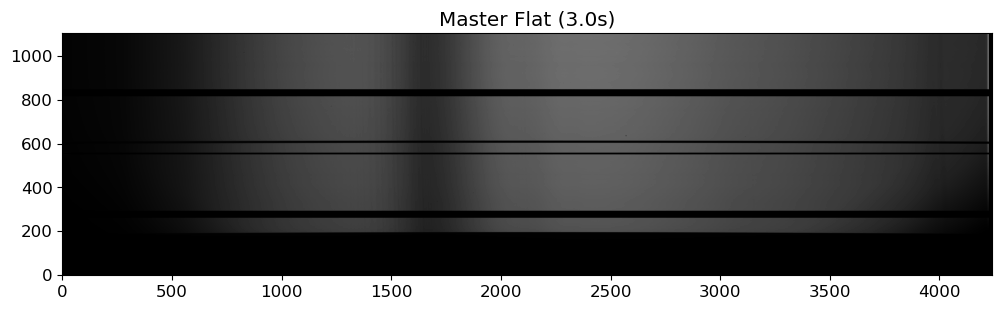

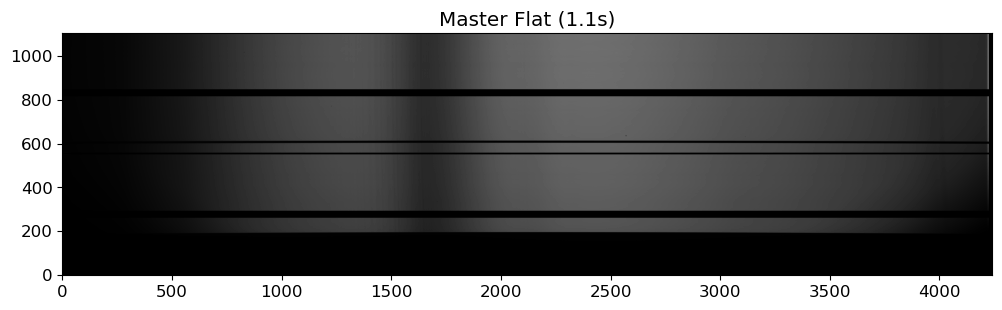

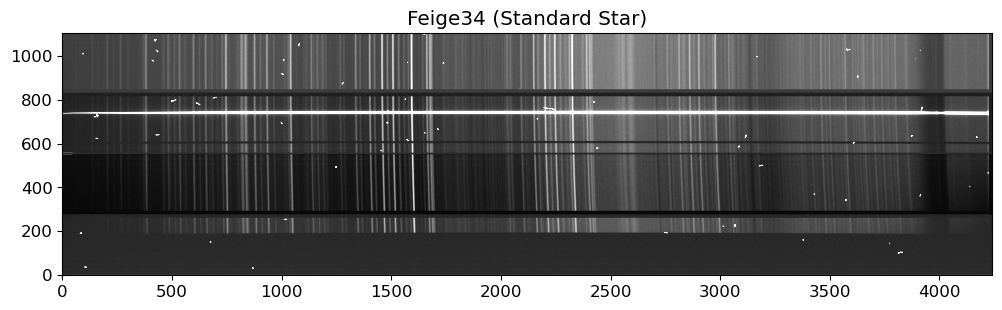

In [9]:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111)
flat03 = fits.getdata(OUTDIR / 'MFlat03.0.fits')
vmin, vmax = interval.get_limits(flat03)
im = ax.imshow(flat03.T, cmap='gray', origin='lower', vmin=vmin, vmax=vmax)
ax.set_title('Master Flat (3.0s)')

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111)
flat01 = fits.getdata(OUTDIR / 'MFlat01.1.fits')
vmin, vmax = interval.get_limits(flat01)
im = ax.imshow(flat03.T, cmap='gray', origin='lower', vmin=vmin, vmax=vmax)
ax.set_title('Master Flat (1.1s)')

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111)
f34 = fits.getdata(RAWDIR / stdtab_f34['filename'][0])
vmin, vmax = interval.get_limits(f34)
im = ax.imshow(f34.T, cmap='gray', origin='lower', vmin=vmin, vmax=vmax)
ax.set_title('Feige34 (Standard Star)')

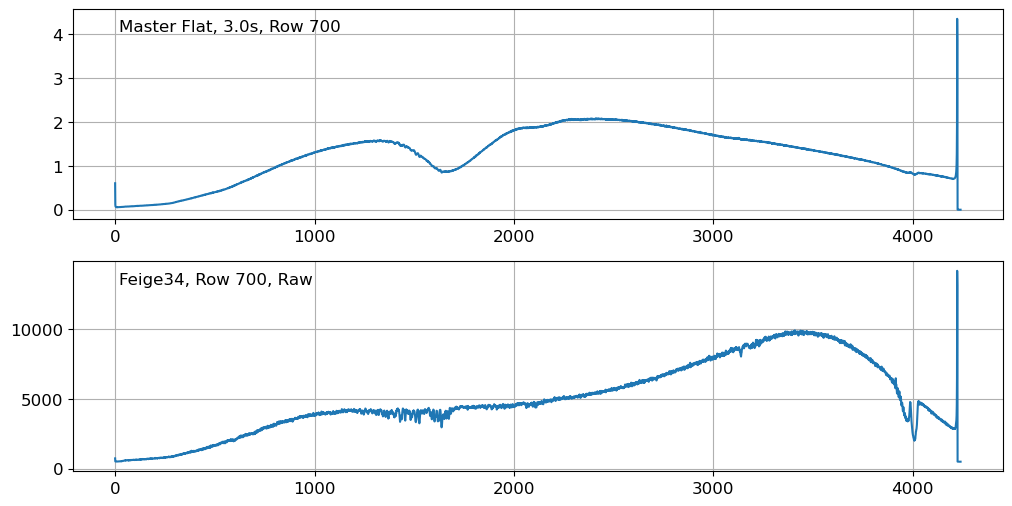

In [10]:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(211)
ax.plot(flat03[:, 700])
ax.text(0.05, 0.95, 'Master Flat, 3.0s, Row 700', transform=ax.transAxes,
        ha='left', va='top')
ax.grid()
ax = fig.add_subplot(212)
ax.plot(f34[:, 737])
ax.text(0.05, 0.95, 'Feige34, Row 700, Raw', transform=ax.transAxes,
        ha='left', va='top')
ax.grid()

Although we can see some tiny wiggles in the flat spectrum, this is not significant enough to adopt higher-order polynomials to model the flat spectrum, as opposed to the case if we have significant fringe patterns. If you closely examine the flat spectrum, you will see that the wiggles are not random, but rather located at the atmospheric absorption lines. This is because the flat image is taken with a lamp, and the lamp light is absorbed by the atmosphere at these absorption lines. Since the absorption lines are not random, we can safely ignore them when modeling the flat spectrum.

Here we model the flat spectrum with median filtering, which is a simple and effective way to remove noise while preserving the shape of the spectrum. We will use a median filter in the dispersion direction to model the flat spectrum, with a window size of 100 pixels. This is a good starting point, but you may need to adjust the window size depending on the complexity of the flat spectrum.

:::{note}
Although I compared the horizontal profile of the standard star and the flat image for convenience, it might as well natural to compare the final extracted spectra of the standard star after applying both the high-order and low-order model of the flat field.
:::

For simplicity, we will only use the combined flat image taken with the exposure time of 3 seconds. In practice, you may use all the flat images taken with different exposure times to make a master flat, or you can use the flat images taken with long and short exposure times to make a bad pixel map.


In [11]:
# median filtering the flat field image along the dispersion axis
flat03_filt = median_filter(flat03, size=50, axes=0)
# normalizing the flat field image
normflat = flat03 / flat03_filt

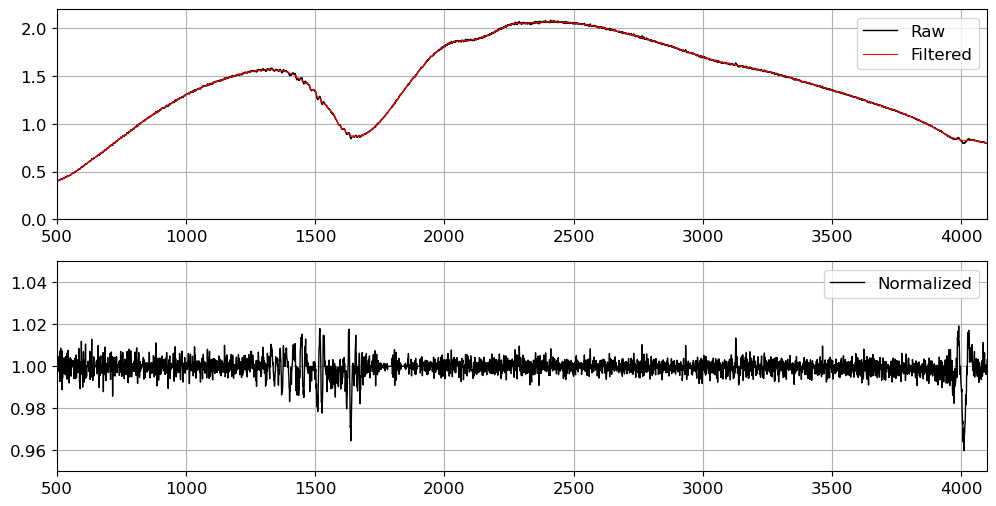

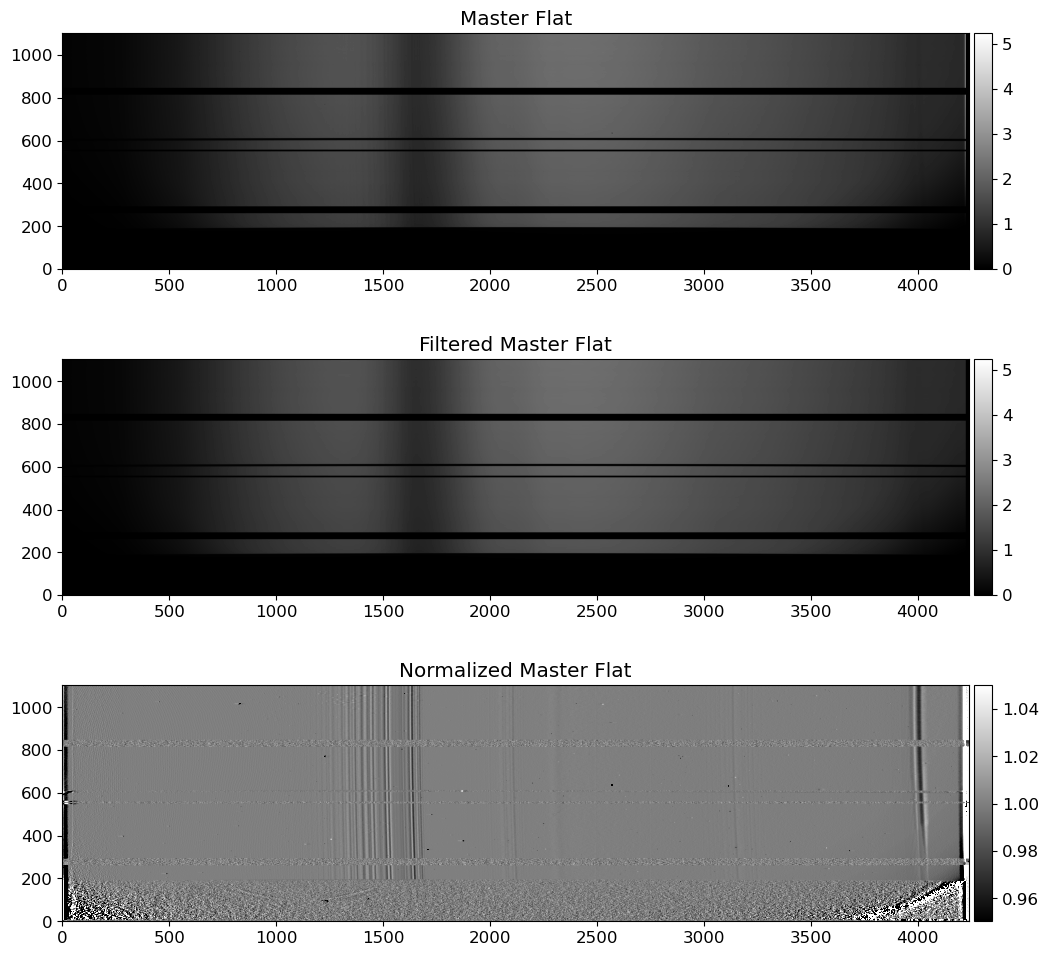

In [12]:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(211)
ax.plot(flat03[:, 700], c='k', label='Raw', lw=1)
ax.plot(flat03_filt[:, 700], c='r', label='Filtered', lw=0.8)
ax.set_xlim(500, 4100)
ax.set_ylim(0,2.2)
ax.legend()
ax.grid()
ax = fig.add_subplot(212)
ax.plot(normflat[:, 700], c='k', label='Normalized', lw=1)
ax.set_xlim(500, 4100)
ax.set_ylim(0.95, 1.05)
ax.legend()
ax.grid()

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(311)
vmin, vmax = interval.get_limits(flat03)
im = ax.imshow(flat03.T, cmap='gray', origin='lower', vmin=vmin, vmax=vmax)
ax.set_title('Master Flat')
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='2%', pad=0.05)
plt.colorbar(im, cax=cax)
ax = fig.add_subplot(312)
im = ax.imshow(flat03_filt.T, cmap='gray', origin='lower', vmin=vmin, vmax=vmax)
ax.set_title('Filtered Master Flat')
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='2%', pad=0.05)
plt.colorbar(im, cax=cax)
ax = fig.add_subplot(313)
vmin, vmax = interval.get_limits(normflat)
im = ax.imshow(normflat.T, cmap='gray', origin='lower', vmin=vmin, vmax=vmax)
ax.set_title('Normalized Master Flat')
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='2%', pad=0.05)
plt.colorbar(im, cax=cax)

In [13]:
# writing the normalized flat field image to a file
hdr = fits.getheader(OUTDIR / 'MFlat03.0.fits')
hdu = fits.PrimaryHDU(normflat, header=hdr)
hdu.writeto(OUTDIR / 'nMFlat03.0.fits', overwrite=True)

### Preprocessing the Raw Images

Now we will preprocess the raw images. We will subtract the master bias and divide the master flat from the raw science frames. These preprocessed science frames will not be combined, since the spatial location of the object is different in each frame. We will combine the light from the object after extracting the 1D spectrum.

In [14]:
mbias = OUTDIR / 'MBias.fits'
mflat = OUTDIR / 'nMFlat03.0.fits'
# preprocessing the arc image
arc_list = [RAWDIR / f for f in arctab['filename']]
print('Preprocessing arc images...')
arc = preproc.preproc(arc_list, mbias=mbias, mflat=mflat, outdir=OUTDIR)

# combine the preprocessed arc image
print('Combining the preprocessed arc images...')
parcs = [CCDData.read(OUTDIR / ('p'+f.stem)) for f in arc_list]
carc = combine(parcs, method='average', sigma_clip=True, sigma_clip_low_thresh=3,
               sigma_clip_high_thresh=3)

carc.write(OUTDIR / 'cArc.fits', overwrite=True)
print('The combined arc image is saved as cArc.fits')

# preprocessing the science image
print('Preprocessing science images...')
sci_list = [RAWDIR / f for f in scitab['filename']]
_ = preproc.preproc(sci_list, mbias=mbias, mflat=mflat, outdir=OUTDIR, insert_ivar=True)

# preprocessing the standard star images
print('Preprocessing standard star images...')
print('Standard star: Feige110')
std_list_f110 = [RAWDIR / f for f in stdtab_f110['filename']]
_ = preproc.preproc(std_list_f110, mbias=mbias, mflat=mflat, outdir=OUTDIR,
                    insert_ivar=True)
print('Standard star: Feige34')
std_list_f34 = [RAWDIR / f for f in stdtab_f34['filename']]
_ = preproc.preproc(std_list_f34, mbias=mbias, mflat=mflat, outdir=OUTDIR,
                    insert_ivar=True)

Preprocessing arc images...
Done: pFCSA00141840.fits


/Users/hbahk/class/TAOtutorials/tutorials/preproc.py:295: RuntimeWarning: invalid value encountered in divide
  sci_data /= mflat_data    # Flat fielding


Done: pFCSA00141882.fits
Done: pFCSA00141580.fits
Combining the preprocessed arc images...
INFO: An exception happened while extracting WCS information from the Header.
InconsistentAxisTypesError: ERROR 4 in wcs_types() at line 3140 of file cextern/wcslib/C/wcs.c:
Unmatched celestial axes.
 [astropy.nddata.ccddata]
INFO: An exception happened while extracting WCS information from the Header.
InconsistentAxisTypesError: ERROR 4 in wcs_types() at line 3140 of file cextern/wcslib/C/wcs.c:
Unmatched celestial axes.
 [astropy.nddata.ccddata]
INFO: An exception happened while extracting WCS information from the Header.
InconsistentAxisTypesError: ERROR 4 in wcs_types() at line 3140 of file cextern/wcslib/C/wcs.c:
Unmatched celestial axes.
 [astropy.nddata.ccddata]


this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set DATE-END to '2013-06-07T04:55:27.734' from MJD-END'. [astropy.wcs.wcs]
  'degree' -> 'deg'. [astropy.wcs.wcs]
Set DATE-END to '2013-06-07T05:51:12.249' from MJD-END'. [astropy.wcs.wcs]
Set DATE-END to '2013-06-06T04:52:48.140' from MJD-END'. [astropy.wcs.wcs]
/opt/anaconda3/envs/main/lib/python3.11/site-packages/ccdproc/combiner.py:548: RuntimeWarning: Mean of empty slice
  mean = scale_func(data, axis=0)
/opt/anaconda3/envs/main/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


The combined arc image is saved as cArc.fits
Preprocessing science images...
Done: pFCSA00141920.fits


/Users/hbahk/class/TAOtutorials/tutorials/preproc.py:295: RuntimeWarning: invalid value encountered in divide
  sci_data /= mflat_data    # Flat fielding


Done: pFCSA00141930.fits
Done: pFCSA00141916.fits
Done: pFCSA00141928.fits
Done: pFCSA00141938.fits
Done: pFCSA00141940.fits
Done: pFCSA00141918.fits
Done: pFCSA00141936.fits
Done: pFCSA00141926.fits
Preprocessing standard star images...
Standard star: Feige110
Done: pFCSA00142004.fits
Done: pFCSA00142006.fits
Done: pFCSA00142010.fits
Standard star: Feige34
Done: pFCSA00141880.fits
Done: pFCSA00141894.fits
Done: pFCSA00141878.fits


Text(0.5, 1.0, 'Preprocessed Feige110 Image')

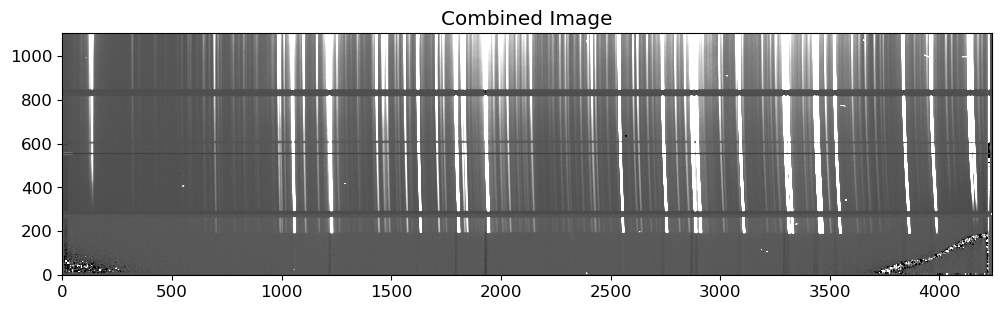

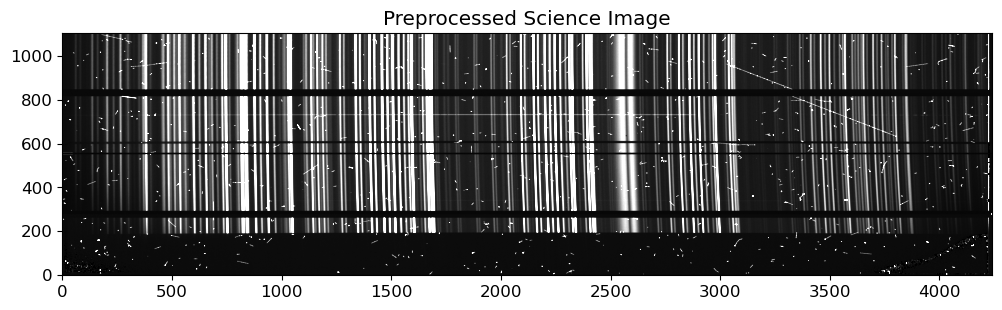

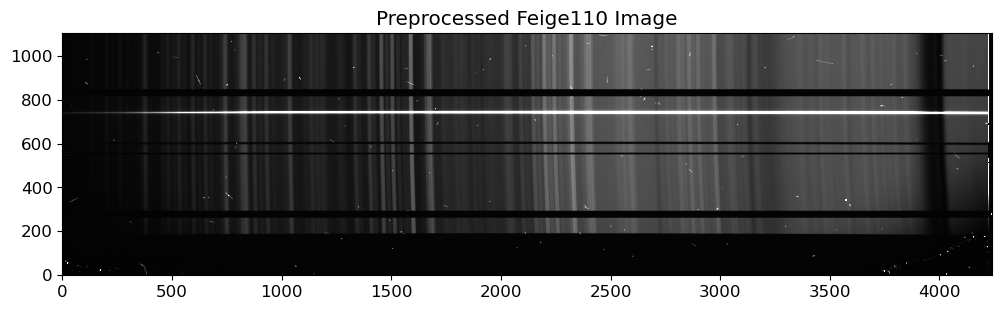

In [15]:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111)
vmin, vmax = interval.get_limits(carc.data)
im = ax.imshow(carc.data.T, cmap='gray', origin='lower', vmin=vmin, vmax=vmax)
ax.set_title('Combined Image')

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111)
sci = fits.getdata(OUTDIR / f'p{sci_list[0].stem}')
vmin, vmax = interval.get_limits(sci)
im = ax.imshow(sci.T, cmap='gray', origin='lower', vmin=vmin, vmax=vmax)
ax.set_title('Preprocessed Science Image')

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111)
std110 = fits.getdata(OUTDIR / f'p{std_list_f110[0].stem}')
vmin, vmax = interval.get_limits(std110)
im = ax.imshow(std110.T, cmap='gray', origin='lower', vmin=vmin, vmax=vmax)
ax.set_title('Preprocessed Feige110 Image')

## Extracting 1D Spectra

The 1D spectra are extracted from the 2D science frames by summing the flux along the spatial direction. The extraction process consists of the following steps:

1. **Source Identification**: Identify the source in the 2D science frame.
2. **Aperture Tracing**: Trace the spatial position of the source along the dispersion direction.
3. **Aperture Summation**: Sum the flux along the trace to extract the 1D spectrum.

Let's extract the 1D spectra of the standard star first, because it is brighter and easier to extract.


Text(0.5, 1.0, 'Preprocessed Feige110 Image (Trimmed)')

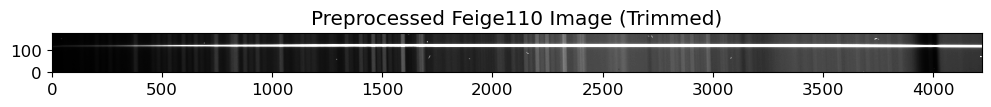

In [16]:
# Let's trim the images to the region of interest
TRIM = [0, 4220, 620, 800] # y_lower, y_upper, x_lower, x_upper
fname = OUTDIR / f'p{std_list_f110[0].stem}'
stdhdu = fits.open(fname)
stdtrim = stdhdu[0].data[TRIM[0]:TRIM[1], TRIM[2]:TRIM[3]]
exptime = stdhdu[0].header['EXPTIME']
stdhdr = stdhdu[0].header

fig = plt.figure(figsize=(12, 2))
ax = fig.add_subplot(111)
vmin, vmax = interval.get_limits(stdtrim)
im = ax.imshow(stdtrim.T, cmap='gray', origin='lower', vmin=vmin, vmax=vmax)
ax.set_title('Preprocessed Feige110 Image (Trimmed)')

In [17]:
stdhdr['GAIN']

2.082

In [18]:
# cosmic ray removal
stdccd = CCDData(data=stdtrim, header=stdhdr, unit='adu')
gcorr = gain_correct(stdccd, gain=stdhdr['GAIN'])
